In [1]:
import os
import re
import csv
import ray
import random
import datetime

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from util import *
from estimator import *
from evaluator import run_grid_search

os.environ.pop('http_proxy', None)

'http://192.168.0.1:8123'

### Parse DBPEDIA data (https://arxiv.org/pdf/2102.09690)

In [2]:
input_file = Path('./data/DBPEDIA/test.csv')
results_folder = Path('./data/DBPEDIA_RESULTS')
processed_data_file = Path('./data/DBPEDIA_RESULTS/data.json')
dataset = 'DBPEDIA'
class_labels = ["Company",
                "Educational Institution",
                "Artist",
                "Athlete",
                "Office Holder",
                "Mean Of Transportation",
                "Building", 
                "Natural Place",
                "Village",
                "Animal",
                "Plant",
                "Album", 
                "Film",
                "Written Work",
                "N/A"]

class_labels_to_id = {c_name: i for i, c_name in enumerate(class_labels)}

def parse_DBPEDIA(csv_file_path):
    
    data = []
    with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csvreader = csv.DictReader(csvfile)
        for row_id, row in enumerate(csvreader, start=1):
            # Extract values from the CSV row
            class_value = class_labels[int(row['Class'])-1]
            text_value = row['Text']
            
            # Create a dictionary representing the row
            row_dict = {
                'id': row_id,
                'class': class_value,
                'input': text_value
            }
            
            # Append the row dictionary to the list
            data.append(row_dict)
    
    return data


def balance_dataset(class_labels, samples, total_samples):
    # Shuffle the samples
    random.shuffle(samples)
    
    n_samples_per_class = total_samples // len(class_labels)
    balanced_dataset = []
    class_count = {label: 0 for label in class_labels}
    
    remaining_samples = []
    
    for sample in samples:
        label = sample['class']
        if class_count[label] < n_samples_per_class:
            balanced_dataset.append(sample)
            class_count[label] += 1
        else:
            remaining_samples.append(sample)
    
    # If we still need more samples to reach total_samples, randomly sample from remaining samples
    while len(balanced_dataset) < total_samples and remaining_samples:
        random_sample = random.choice(remaining_samples)
        balanced_dataset.append(random_sample)
        remaining_samples.remove(random_sample)
    
    # Now, extract one sample per class from the remaining samples
    one_sample_per_class = []
    for label in class_labels:
        for s in remaining_samples:
            if s['class'] == label:
                one_sample_per_class.append(s)
                break
                
    return balanced_dataset[:total_samples], one_sample_per_class  # Ensure exactly total_samples in the output


n_samples = 2000
random.seed(42)

if not os.path.exists(processed_data_file):
    data_list, one_shot_examples = balance_dataset(class_labels[:-1], parse_DBPEDIA(input_file), n_samples)  # do not count NA
    
    # Serialize the dictionary to a JSON string
    json_data = json.dumps((data_list, one_shot_examples))
    
    # Write the JSON string to a file
    with open(processed_data_file, 'w') as f:
        f.write(json_data)
else:
    with open(processed_data_file, 'r') as f:
        data_list, one_shot_examples = json.load(f)

sample_ids = [s["id"] for s in data_list]


def class_extractor_fun(text):
    # we might want to check if more than a word is returned, but does not seem strictly necessary
    for l in class_labels:
        if l.lower() in text.lower():
            return l
    # if no label has been found
    return "N/A"

In [3]:
s_id = 1
print(data_list[s_id]['input'])
print(data_list[s_id]['class'])

for s in one_shot_examples:
    print(s['class'])

 Darkman is a 1990 American superhero action film directed and co-written by Sam Raimi. It is based on a short story Raimi wrote that paid homage to Universal's horror films of the 1930s.
Film
Company
Educational Institution
Artist
Athlete
Office Holder
Mean Of Transportation
Building
Natural Place
Village
Animal
Plant
Album
Film
Written Work


## Run a grid search over parameters

In [4]:
question_to_rewrite = "Classify the text based on whether their subject is a Company, Educational Institution, Artist, Athlete, Office Holder, Mean Of Transportation, Building, Natural Place, Village, Animal, Plant, Album,  Film, or Written Work."

prompt_simple = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their subject is a Company, Educational Institution, Artist, Athlete, Office Holder, Mean Of Transportation, Building, Natural Place, Village, Animal, Plant, Album,  Film, or Written Work.\nAnswer with the class name only.\nThe possible classes are: Company, Educational Institution, Artist, Athlete, Office Holder, Mean Of Transportation, Building, Natural Place, Village, Animal, Plant, Album,  Film, and Written Work.\nHere is the text: {summary}"]    
]

prompt_instruct = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their subject is a Company, Educational Institution, Artist, Athlete, Office Holder, Mean Of Transportation, Building, Natural Place, Village, Animal, Plant, Album,  Film, or Written Work.\nAnswer with the class name only.\nThe possible classes are: \n- Company: An organization engaged in commercial, industrial, or professional activities, aiming to generate profit through the provision of goods or services.\n- Educational Institution: An establishment dedicated to teaching and learning, ranging from primary schools to universities and research institutes.\n- Artist: A creative individual who produces artworks, such as paintings, sculptures, music, or performances, to express ideas and evoke emotions.\n- Athlete: A person who competes in sports or physical activities, often at a professional level, requiring training, skill, and physical prowess.\n- Office Holder: An individual who occupies a formal position of authority or responsibility within an organization, government, or other entity.\n- Mean of Transportation: Any vehicle or system used to move people or goods from one place to another, such as cars, trains, planes, or bicycles.\n- Building: A structure with a roof and walls, such as a house, office, or factory, intended for occupancy or use for various purposes.\n- Natural Place: A location characterized by natural features and landscapes, such as forests, mountains, lakes, or beaches, often untouched by human activity.\n- Village: A small, rural community typically smaller than a town, with a close-knit population and local governance.\n- Animal: A living organism that feeds on organic matter, typically having specialized sense organs and nervous systems and able to respond rapidly to stimuli.\n- Plant: A multicellular organism that typically produces its own food through photosynthesis, forming a fundamental part of Earth's ecosystems.\n- Album: A collection of audio recordings issued as a single item, usually consisting of several tracks by a musician or band.\n- Film: A motion picture or movie, created by recording moving images and sound to tell a story or document reality.\n- Written Work: Any form of text, such as a book, article, or essay, created to communicate information, ideas, or narratives through written language.\nHere is the text: {summary}"]    
]

prompt_fewshot = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their subject is a Company, Educational Institution, Artist, Athlete, Office Holder, Mean Of Transportation, Building, Natural Place, Village, Animal, Plant, Album,  Film, or Written Work.\nAnswer with the class name only.\nThe possible classes are: \n- Company: An organization engaged in commercial, industrial, or professional activities, aiming to generate profit through the provision of goods or services.\n- Educational Institution: An establishment dedicated to teaching and learning, ranging from primary schools to universities and research institutes.\n- Artist: A creative individual who produces artworks, such as paintings, sculptures, music, or performances, to express ideas and evoke emotions.\n- Athlete: A person who competes in sports or physical activities, often at a professional level, requiring training, skill, and physical prowess.\n- Office Holder: An individual who occupies a formal position of authority or responsibility within an organization, government, or other entity.\n- Mean of Transportation: Any vehicle or system used to move people or goods from one place to another, such as cars, trains, planes, or bicycles.\n- Building: A structure with a roof and walls, such as a house, office, or factory, intended for occupancy or use for various purposes.\n- Natural Place: A location characterized by natural features and landscapes, such as forests, mountains, lakes, or beaches, often untouched by human activity.\n- Village: A small, rural community typically smaller than a town, with a close-knit population and local governance.\n- Animal: A living organism that feeds on organic matter, typically having specialized sense organs and nervous systems and able to respond rapidly to stimuli.\n- Plant: A multicellular organism that typically produces its own food through photosynthesis, forming a fundamental part of Earth's ecosystems.\n- Album: A collection of audio recordings issued as a single item, usually consisting of several tracks by a musician or band.\n- Film: A motion picture or movie, created by recording moving images and sound to tell a story or document reality.\n- Written Work: Any form of text, such as a book, article, or essay, created to communicate information, ideas, or narratives through written language.\n"]    
]
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "Here are a few examples:\n"
for s in one_shot_examples:
    prompt_fewshot[1][1] = prompt_fewshot[1][1] + f"Class {s['class']}: {s['input']}\n" 
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "\nHere is the text: {summary}"

prompt_types = {"simple": prompt_simple,
                "instruct": prompt_instruct,
                "fewshot": prompt_fewshot,
                }

# print(prompt_fewshot)

llms = ['llama3', 'mixtral']#, 'gpt-3.5', 'gpt-4o']
Qs = [30] # number of equivalent but alternative questions compared to original question
temp_questions = [0.]#list(np.arange(0., 1.25, 0.25))  # temperature of the LLM used to produce questions
As = [1] # number of alternative answers for each questions
temp_answers =  [0.] # list(np.arange(0., 1.5, 0.25))  # temperature of the LLM used to produce answers

samples = data_list
n_samples = len(samples)
print(f'Num test examples is {len(samples)}')

Num test examples is 2000


In [ ]:
run_grid_search(samples,
                llms,
                prompt_types,
                Qs,
                temp_questions,
                question_to_rewrite,
                As,
                temp_answers,
                class_labels,
                class_extractor_fun,
                results_folder)

2024-08-03 20:21:30,483	INFO worker.py:1621 -- Started a local Ray instance.


Skipping test 21210_llama3_30_1_0.0_0.0
Skipping test 63788_llama3_30_1_0.0_0.0
Skipping test 69974_llama3_30_1_0.0_0.0
Skipping test 60536_llama3_30_1_0.0_0.0
Skipping test 51657_llama3_30_1_0.0_0.0
Skipping test 57673_llama3_30_1_0.0_0.0
Skipping test 32514_llama3_30_1_0.0_0.0
Skipping test 23437_llama3_30_1_0.0_0.0
Skipping test 24152_llama3_30_1_0.0_0.0
Skipping test 772_llama3_30_1_0.0_0.0
Skipping test 66076_llama3_30_1_0.0_0.0
Skipping test 26574_llama3_30_1_0.0_0.0
Skipping test 21_llama3_30_1_0.0_0.0
Skipping test 46495_llama3_30_1_0.0_0.0
Skipping test 69393_llama3_30_1_0.0_0.0
Skipping test 25828_llama3_30_1_0.0_0.0
Skipping test 32234_llama3_30_1_0.0_0.0
Skipping test 66124_llama3_30_1_0.0_0.0
Skipping test 64280_llama3_30_1_0.0_0.0
Skipping test 29843_llama3_30_1_0.0_0.0
Skipping test 5760_llama3_30_1_0.0_0.0
Skipping test 42939_llama3_30_1_0.0_0.0
Skipping test 34112_llama3_30_1_0.0_0.0
Skipping test 46208_llama3_30_1_0.0_0.0
Skipping test 64198_llama3_30_1_0.0_0.0
Skippi

In [ ]:
plot_TVD_info(sample_ids,
              prompt_types,
              llms,
              Qs,
              temp_questions,
              As,
              temp_answers,
              class_labels,
              results_folder)

In [ ]:
plot_questions_vs_predicted_distribution(sample_ids,
                                        prompt_types,
                                        llms,
                                        Qs,
                                        temp_questions,
                                        As,
                                        temp_answers,
                                        class_labels,
                                        results_folder)

Prompt type: simple


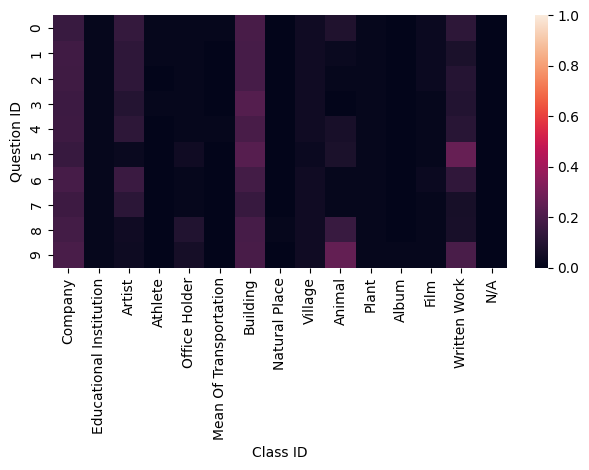

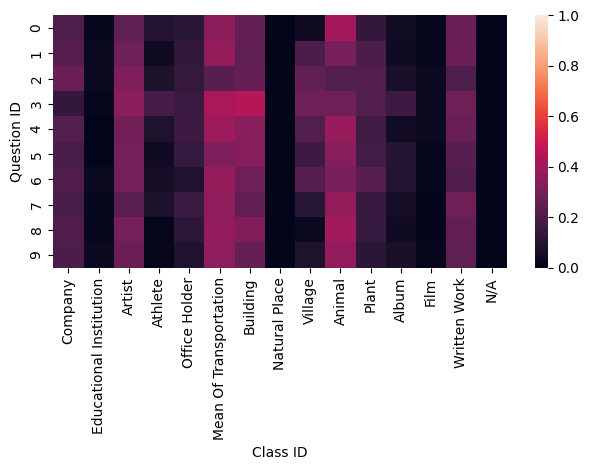

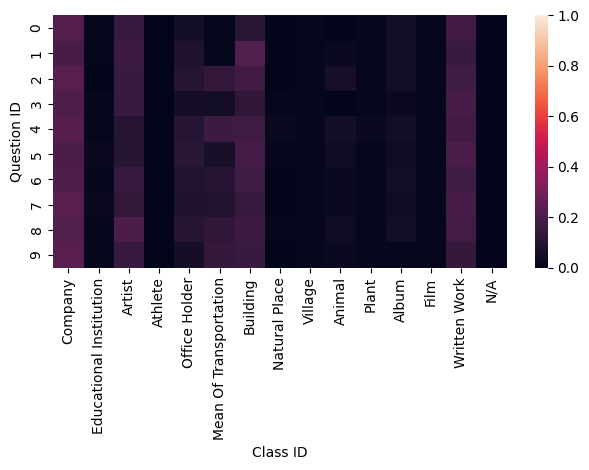

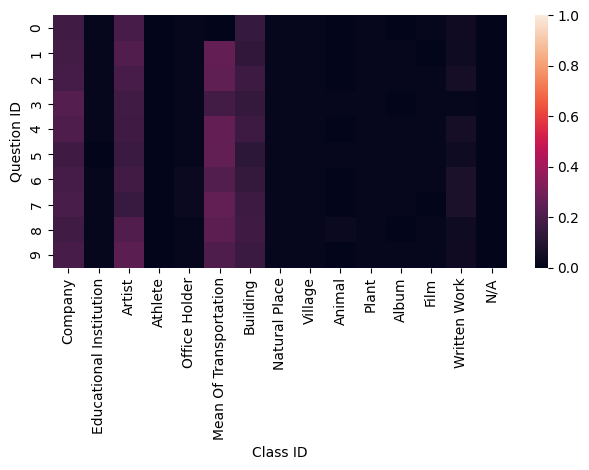

Prompt type: instruct


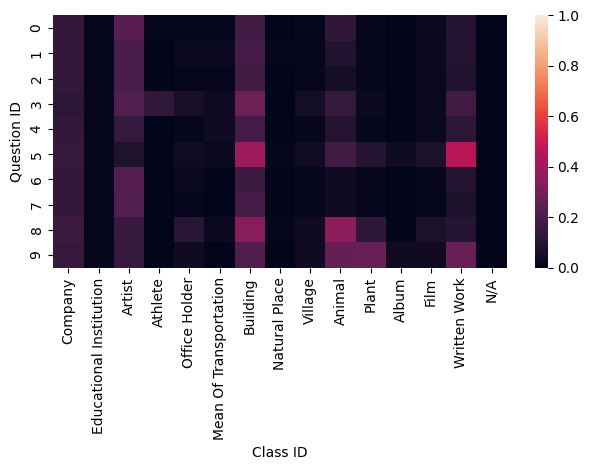

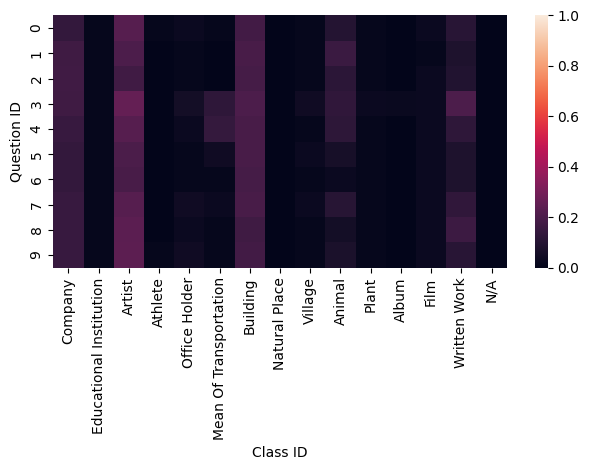

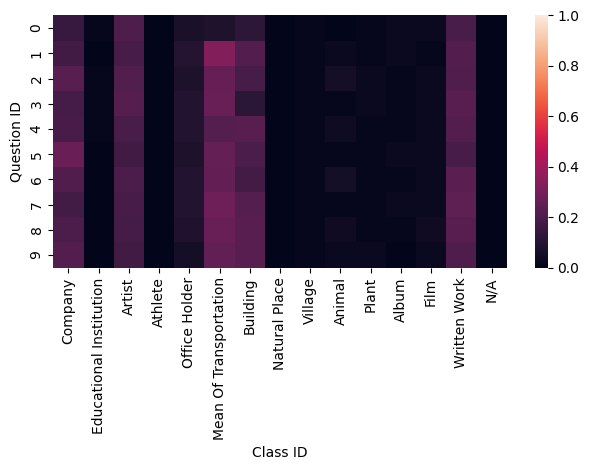

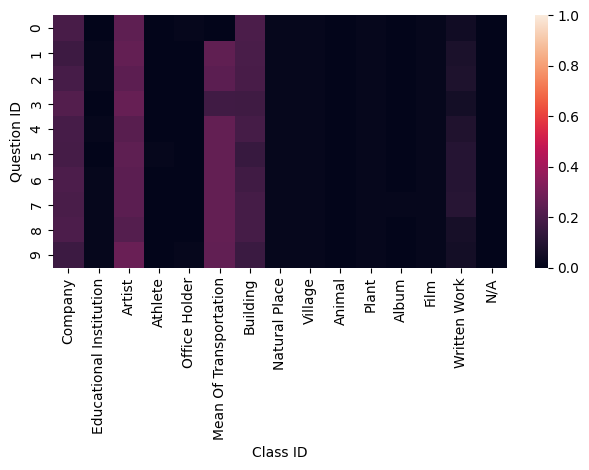

Prompt type: fewshot


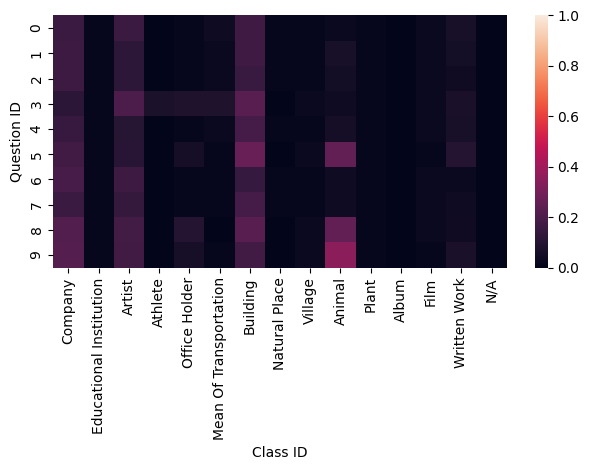

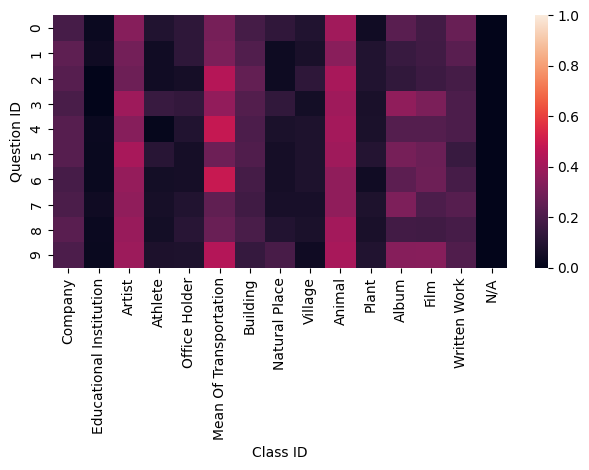

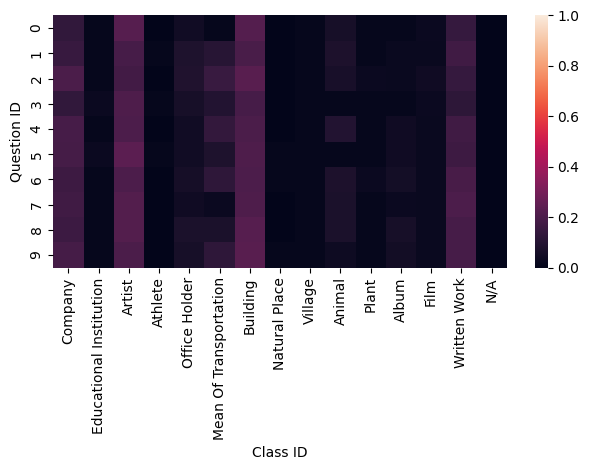

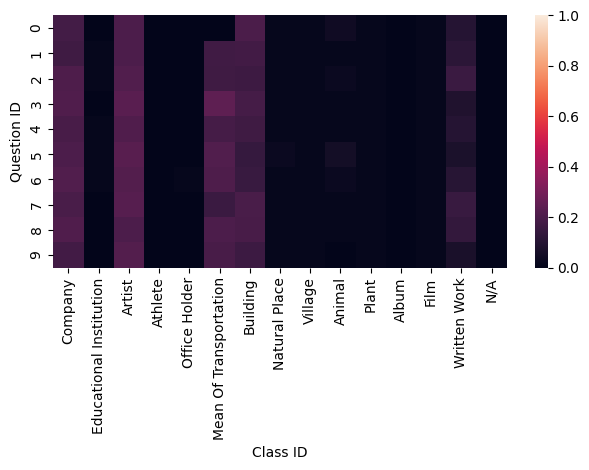

In [5]:
plot_questions_vs_class_sensitivity(sample_ids,
                               prompt_types,
                               llms,
                               Qs,
                               temp_questions,
                               As,
                               temp_answers,
                               class_labels,
                               results_folder)

In [5]:
for llm in ['llama3', 'mixtral']:
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        Q = 30
        A = 1  # MUST stay 1
        temp_question = 0.
        temp_answer = 0.
        max_value = 1
        
        print_classification_scores(sample_ids,
                                    prompt_type,
                                    llm,
                                    Q,
                                    temp_question,
                                    A,
                                    temp_answer,
                                    class_labels,
                                    results_folder)

llama3 simple
Global scores, accuracy: 0.9475, micro f1-score: 0.9475, macro f1-score: 0.8892068996740753
Standard deviation of microf1 score: 0.011707796547600234
llama3 instruct
Global scores, accuracy: 0.74, micro f1-score: 0.74, macro f1-score: 0.7205885421045513
Standard deviation of microf1 score: 0.06223548692935032
llama3 fewshot
Global scores, accuracy: 0.827, micro f1-score: 0.827, macro f1-score: 0.7944802548141605
Standard deviation of microf1 score: 0.03183398341395561
mixtral simple
Global scores, accuracy: 0.804, micro f1-score: 0.804, macro f1-score: 0.7440175136963839
Standard deviation of microf1 score: 0.0256246463390229
mixtral instruct
Global scores, accuracy: 0.862, micro f1-score: 0.8619999999999999, macro f1-score: 0.7990990938393048
Standard deviation of microf1 score: 0.014680145321714872
mixtral fewshot
Global scores, accuracy: 0.819, micro f1-score: 0.819, macro f1-score: 0.7717001046197647
Standard deviation of microf1 score: 0.0203827268920416
gpt-3.5 simp

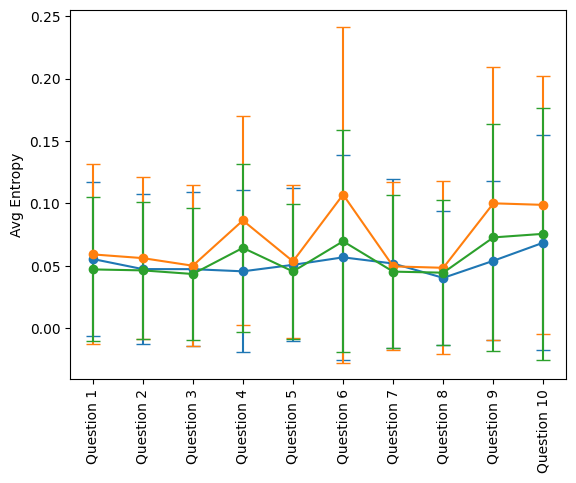

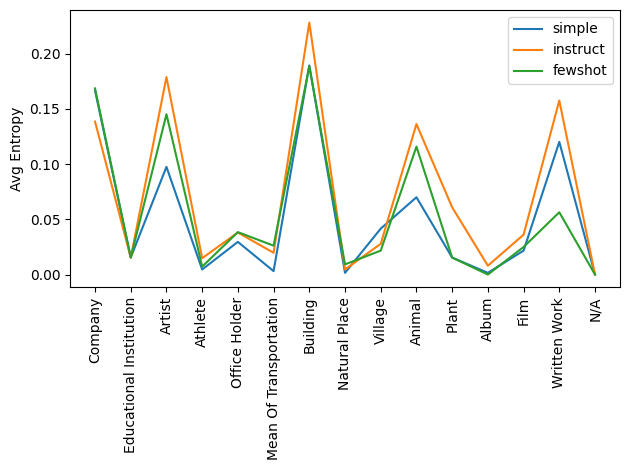

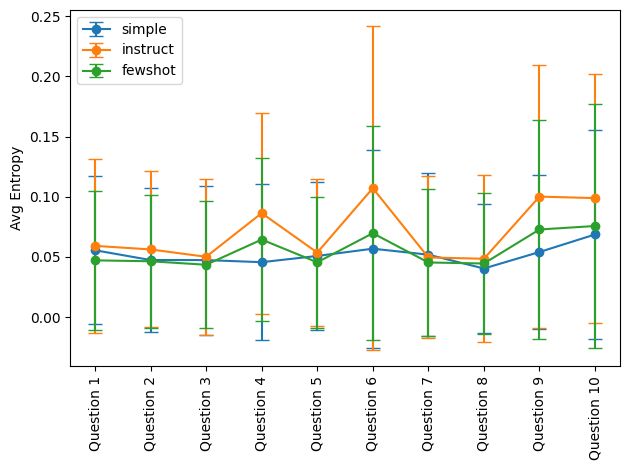

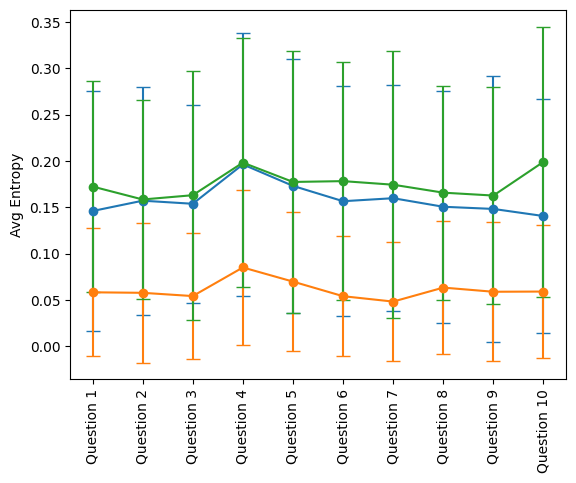

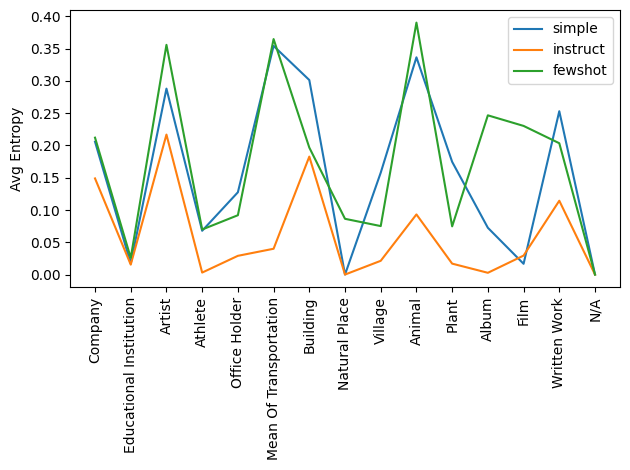

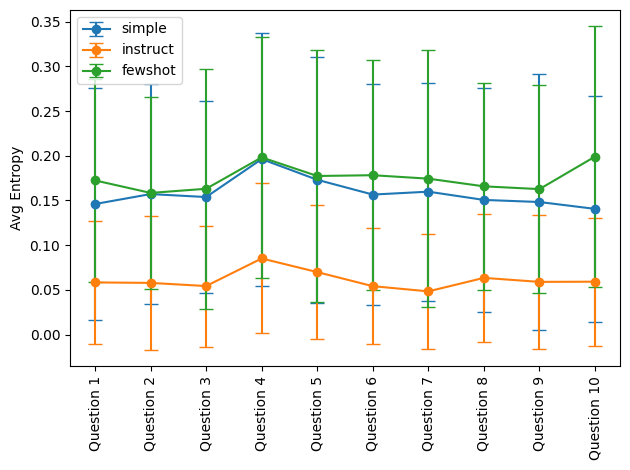

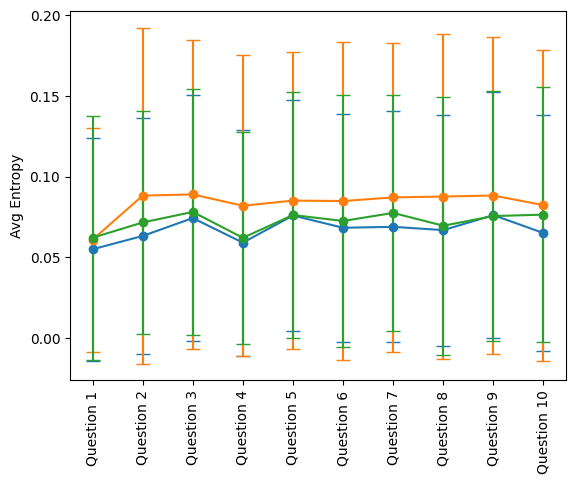

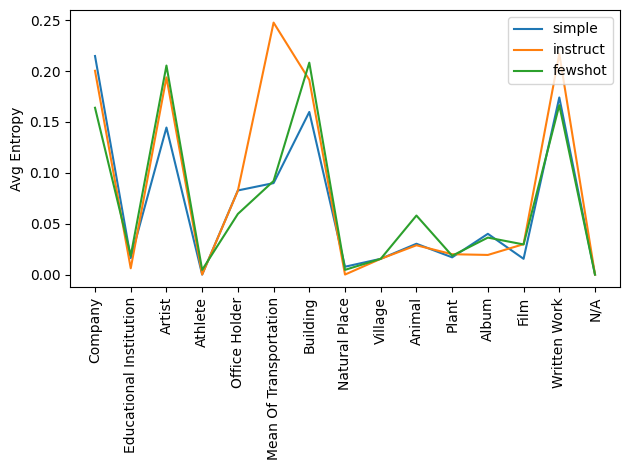

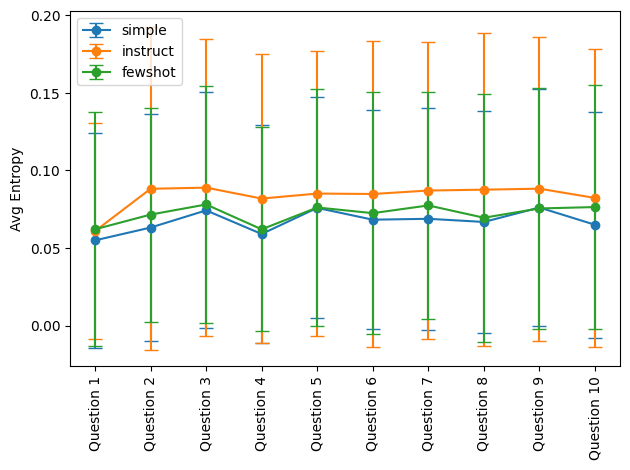

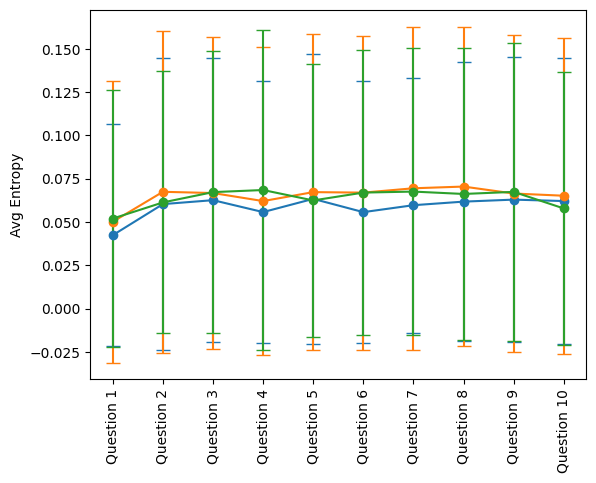

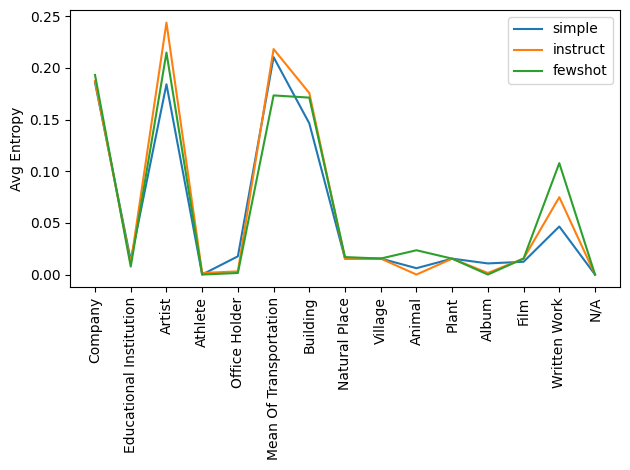

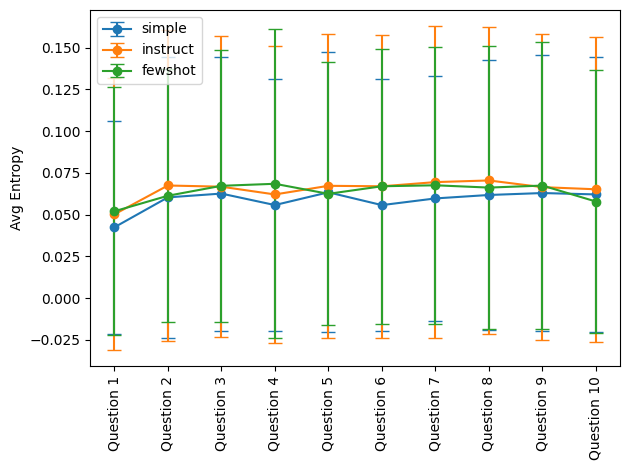

In [7]:
plot_avg_sensitivity(sample_ids,
                 prompt_types,
                 llms,
                 Qs,
                 [0.],
                 As,
                 temp_answers,
                 class_labels,
                 results_folder)

llama3 simple
Avg Entropy over samples: 0.017993394255344325,Std (over questions): 0.06098288823309036
llama3 instruct
Avg Entropy over samples: 0.05838343622221736,Std (over questions): 0.09567748597849594
llama3 fewshot
Avg Entropy over samples: 0.030095130988986595,Std (over questions): 0.07662509629804252


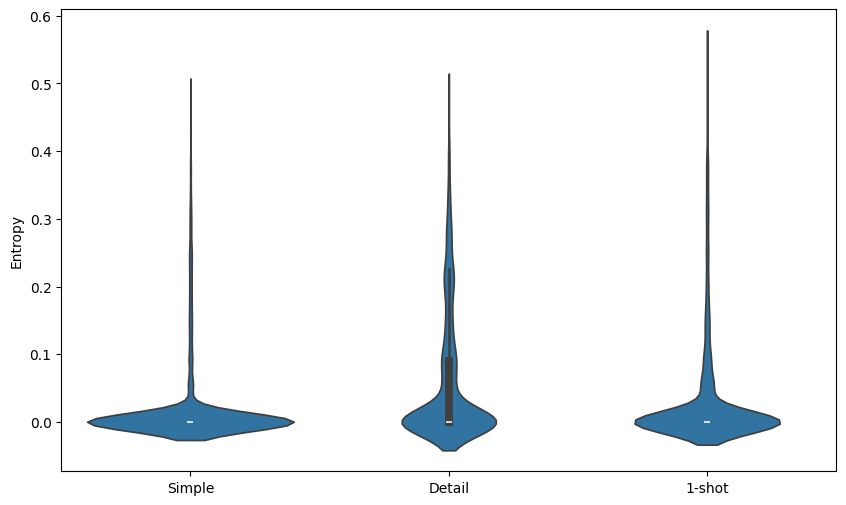

mixtral simple
Avg Entropy over samples: 0.05345547627437224,Std (over questions): 0.104786950328588
mixtral instruct
Avg Entropy over samples: 0.05378185117744206,Std (over questions): 0.11352950197933766
mixtral fewshot
Avg Entropy over samples: 0.06922406571310886,Std (over questions): 0.11528717091131113


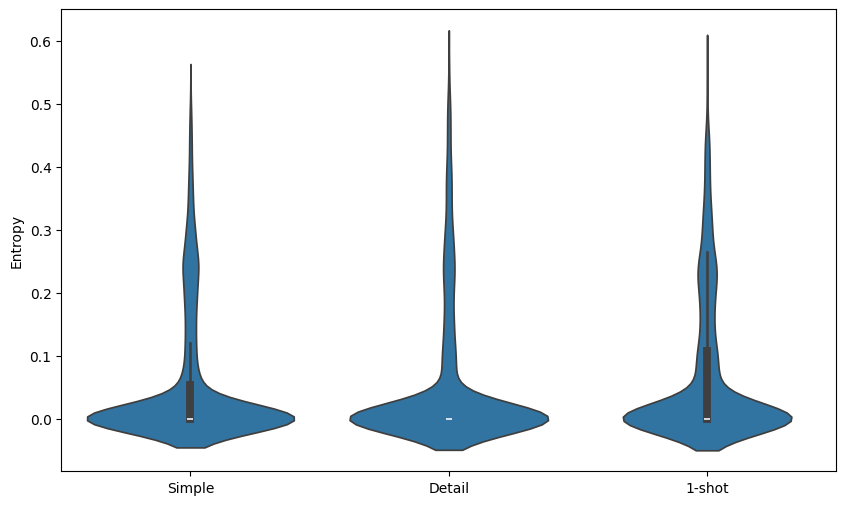

gpt-3.5 simple
Avg Entropy over samples: 0.02583687698978598,Std (over questions): 0.07136096148780122
gpt-3.5 instruct
Avg Entropy over samples: 0.02832515420856172,Std (over questions): 0.08103881521656692
gpt-3.5 fewshot
Avg Entropy over samples: 0.026154374002225665,Std (over questions): 0.07034854689865686


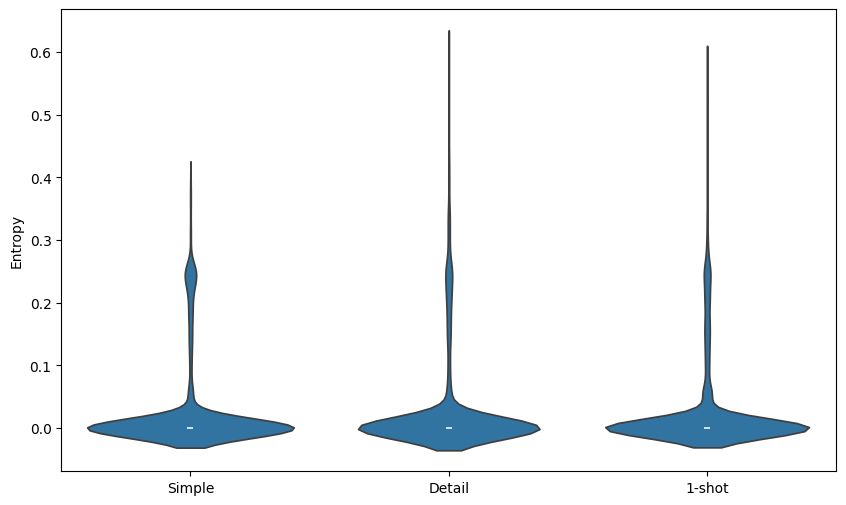

gpt-4o simple
Avg Entropy over samples: 0.02337501748035799,Std (over questions): 0.06984275541903869
gpt-4o instruct
Avg Entropy over samples: 0.022669145103640955,Std (over questions): 0.06838101295628671
gpt-4o fewshot
Avg Entropy over samples: 0.017737644982828548,Std (over questions): 0.057946906515402824


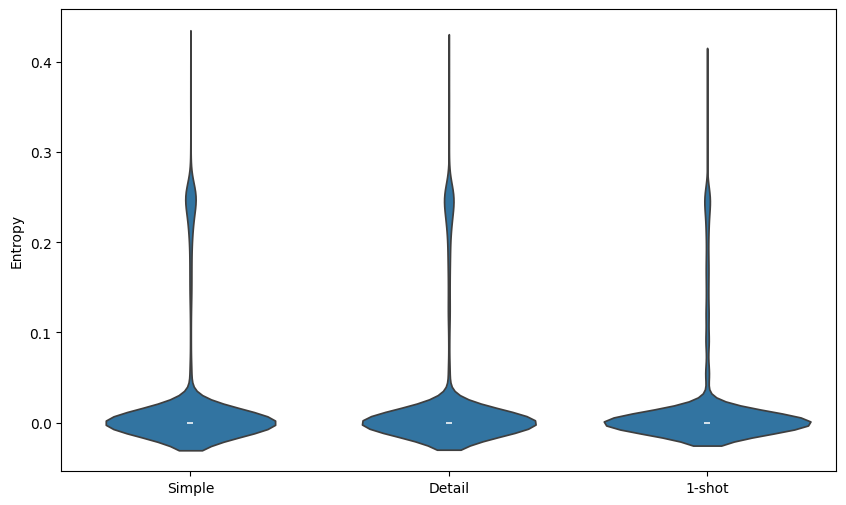

In [6]:
for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)
    
        data.append((em, prompt_type))
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    ax =sns.violinplot(x='Label', y='Values', data=df, split=False)
    plt.xlabel(None)
    ax.set_xticks(np.arange(3)) # <--- set the ticks first
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.ylabel('Entropy')
    plt.show()

In [7]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="DBPedia"

figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder)
    
        for c, TVD_matrix in enumerate(TVD_matrix_per_class):
            data.append((TVD_matrix.reshape(-1), prompt_type))
            
            c_name = class_labels[c]

            # plt.figure(figsize=(figsize[0]+1, figsize[0]))
            # ax = sns.heatmap(TVD_matrix, cbar_kws={'orientation': 'horizontal'})
            # plt.xlabel("Sample ID",fontsize=26)
            # plt.ylabel("Sample ID",fontsize=26)
            # # Adjust the layout to make room for the colorbar
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_matrix_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()

            # sns.histplot(np.reshape(TVD_matrix, -1),
            #                         bins=20, stat='probability', kde=False, color='#3274A1', alpha=1.)
            # plt.xlabel(r"$C_y(x,x')$")
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_hist_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    # plt.figure(figsize=figsize)  # Adjust the figure size if needed
    # ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    # plt.xlabel(None)
    # ax.set_xticks(np.arange(3)) # <--- set the ticks first
    # ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    # plt.ylim(0, 1)
    # plt.ylabel('Consistency')
    # plt.tight_layout()
    # plt.savefig(Path(results_folder, 'paper_figures',
    #         f'consistency_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    # plt.show()

llama3 simple
Prompt type: simple
Avg consistency over classes: 0.9327371827627321,Std consistency over classes: 0.20261420801129873
llama3 instruct
Prompt type: instruct
Avg consistency over classes: 0.9010187058282759,Std consistency over classes: 0.21771973861309493
llama3 fewshot
Prompt type: fewshot
Avg consistency over classes: 0.9237890910278754,Std consistency over classes: 0.2103915076759199
mixtral simple
Prompt type: simple
Avg consistency over classes: 0.8016701549058176,Std consistency over classes: 0.32129946724408703
mixtral instruct
Prompt type: instruct
Avg consistency over classes: 0.8080871149812286,Std consistency over classes: 0.3327018774698943
mixtral fewshot
Prompt type: fewshot
Avg consistency over classes: 0.7735481808657831,Std consistency over classes: 0.3291714702377634
gpt-3.5 simple
Prompt type: simple
Avg consistency over classes: 0.9164544557296951,Std consistency over classes: 0.23045614585213312
gpt-3.5 instruct
Prompt type: instruct
Avg consistency o

llama3 simple
Avg Entropy over samples: 0.017993394255344325,Std (over questions): 0.06098288823309036


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


llama3 instruct
Avg Entropy over samples: 0.05838343622221736,Std (over questions): 0.09567748597849594


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


llama3 fewshot
Avg Entropy over samples: 0.030095130988986595,Std (over questions): 0.07662509629804252


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_921050/3199984982.py:106: UserWarning: set_ticklabels() should 

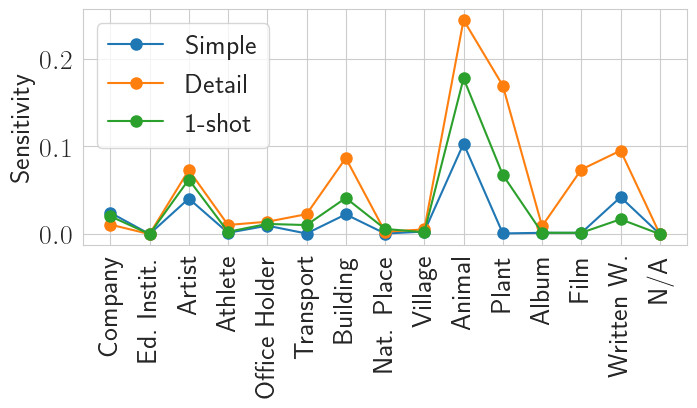

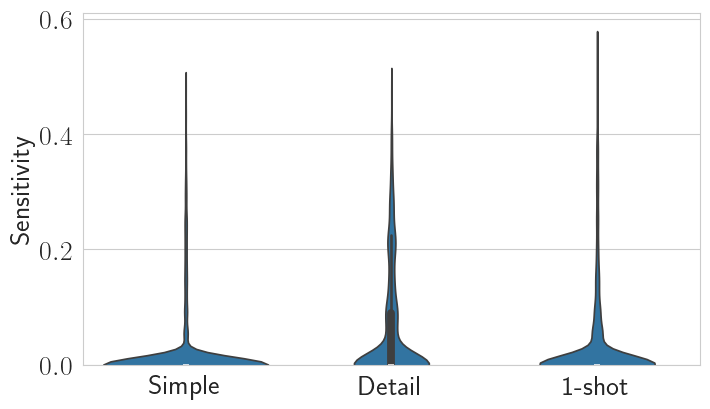

mixtral simple
Avg Entropy over samples: 0.05345547627437224,Std (over questions): 0.104786950328588


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mixtral instruct
Avg Entropy over samples: 0.05378185117744206,Std (over questions): 0.11352950197933766


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mixtral fewshot
Avg Entropy over samples: 0.06922406571310886,Std (over questions): 0.11528717091131113


/tmp/ipykernel_921050/3199984982.py:71: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferrica/.venv/pydgn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_921050/3199984982.py:106: UserWarning: set_ticklabels() should 

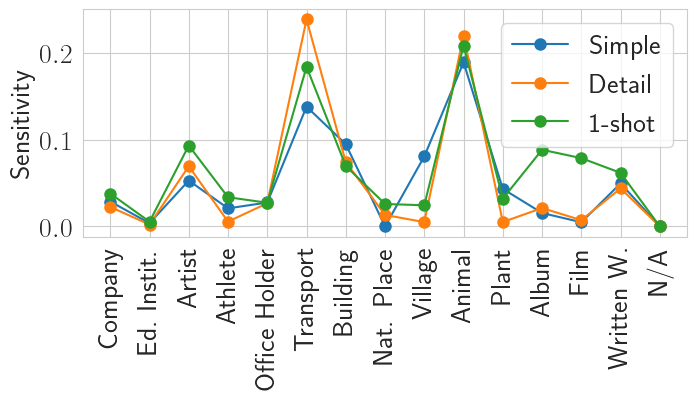

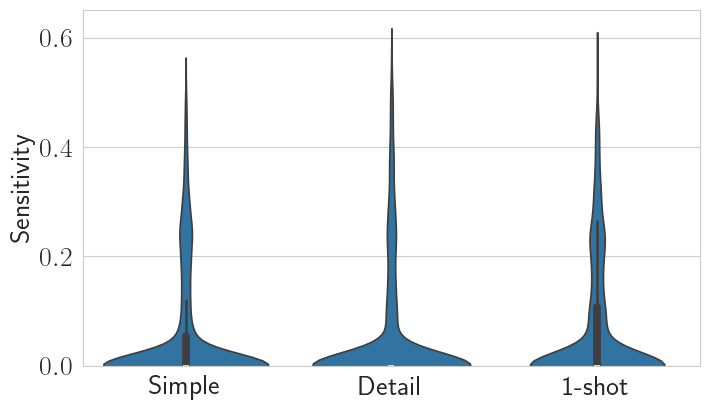

gpt-3.5 simple


KeyError: '21210_gpt-3.5_30_1_0.0_0.0'

<Figure size 750x450 with 0 Axes>

In [8]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14
dataset = 'DBPedia'
sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    errorbar_fig = plt.figure(figsize=figsize)

    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)

        sens_per_class = sensitivity_per_class(sample_ids,
                                               prompt_type,
                                               llm,
                                               Q,
                                               temp_question,
                                               A,
                                               temp_answer,
                                               class_labels,
                                               results_folder)

        # Add error bars (standard deviation)
        plt.figure(errorbar_fig)
        if prompt_type == 'instruct':
            label = 'Detail'
        elif prompt_type == 'fewshot':
            label = '1-shot'
        else:
            label = 'Simple'


        abbr_class_labels = ["Company",
                        "Ed.\ Instit.",
                        "Artist",
                        "Athlete",
                        "Office Holder",
                        "Transport",
                        "Building", 
                        "Nat. Place",
                        "Village",
                        "Animal",
                        "Plant",
                        "Album", 
                        "Film",
                        "Written W.",
                        "N/A"]
        
        sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
        sens_per_class_mean = np.nan_to_num(sens_per_class_mean)
        sens_per_class_std = np.array([np.array(sens_per_class[c]).std() for c in range(len(class_labels))])
        sens_per_class_std = np.nan_to_num(sens_per_class_std)
        # plt.errorbar(np.arange(len(class_labels)), sens_per_class_mean, yerr=sens_per_class_std, fmt='-o',  solid_capstyle='projecting', capsize=5, label=label)
        plt.plot(sens_per_class_mean, label=label, marker='o', markersize=8)
        plt.ylabel('Sensitivity')
        plt.xticks(np.arange(len(abbr_class_labels)),
                            abbr_class_labels,
                            rotation='vertical')      
        plt.legend()
        
        data.append((em, prompt_type))

        plt.figure(errorbar_fig)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_class_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=figsize)  # Adjust the figure size if needed
    ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.xlabel(None)
    plt.ylabel('Sensitivity')
    # Setting the y-axis limits to cut off values below 0
    plt.ylim(0, None)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    plt.show()

llama3 simple
Avg Entropy over samples: 0.011405981249939306,Std (over questions): 0.04804598621639825
llama3 instruct
Avg Entropy over samples: 0.035715576201791936,Std (over questions): 0.07824197128883349
llama3 fewshot
Avg Entropy over samples: 0.017222520346436516,Std (over questions): 0.062277061807858
mixtral simple
Avg Entropy over samples: 0.057514733382667646,Std (over questions): 0.1073830551086228
mixtral instruct
Avg Entropy over samples: 0.02487967994514897,Std (over questions): 0.07194749465894511
mixtral fewshot
Avg Entropy over samples: 0.061947409526318095,Std (over questions): 0.11565501120987234
gpt-3.5 simple
Avg Entropy over samples: 0.01492643539956419,Std (over questions): 0.053924662453829604
gpt-3.5 instruct
Avg Entropy over samples: 0.027302220053232566,Std (over questions): 0.07584790579975512
gpt-3.5 fewshot
Avg Entropy over samples: 0.01728795599931648,Std (over questions): 0.057126705664432766
gpt-4o simple
Avg Entropy over samples: 0.02274776369418695,St

<Figure size 750x450 with 0 Axes>

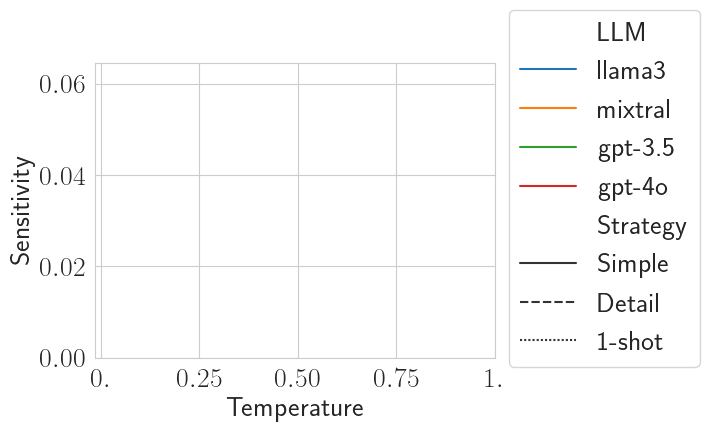

In [11]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

Q = 30
A = 1  # MUST stay 1
temp_answer = 0.


data = []
errorbar_fig = plt.figure(figsize=figsize)
    
for temp_question in temp_questions:
    
    for llm in ['llama3', 'mixtral']:
        
        for prompt_type in ['simple', 'instruct', 'fewshot']:
            print(llm, prompt_type)
            em = print_test_sensitivity_over_samples(sample_ids,
                                            prompt_type,
                                            llm,
                                            Q,
                                            temp_question,
                                            A,
                                            temp_answer,
                                            class_labels,
                                            results_folder)
    
    
            # Add error bars (standard deviation)
            plt.figure(errorbar_fig)
            if prompt_type == 'instruct':
                label = 'Detail'
            elif prompt_type == 'fewshot':
                label = '1-shot'
            else:
                label = 'Simple'
    
            
            data.append((em.mean(), label, llm, int(temp_question/0.25)))
            
        
        
# Create a DataFrame from the expanded data
df = pd.DataFrame(data, columns=['Sensitivity', 'Strategy', 'LLM', 'Temperature'])
print(df)
# Plot the violin plot
plt.figure(figsize=figsize)  # Adjust the figure size if needed
ax = sns.lineplot(x='Temperature', y='Sensitivity', hue='LLM', style='Strategy', data=df)
ax.set_xticks(np.arange(5)) # <--- set the ticks first
ax.set_xticklabels([r'$0.$', r'$0.25$', r'$0.50$', r'$0.75$', r'$1.$'])
# Setting the y-axis limits to cut off values below 0
plt.ylim(0, None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.575))
plt.tight_layout()
plt.savefig(Path(results_folder, 'paper_figures',
            f'sensitivity_vs_temperature_{dataset}_{Q}_{A}_{temp_answer}.pdf'))
plt.show()